In [7]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable


In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt


In [182]:
# Leer archivo con mediciones
archivo = 'Curvas_Medidas_Motor_2025.xls'
datos = pd.read_excel(archivo, sheet_name='Hoja1',header=None)
nombres = pd.read_excel(archivo, sheet_name='Hoja2', header=None).iloc[0].values


In [183]:
# Asignar los nombres a las columnas de 'datos'
datos.columns = nombres


In [184]:
t = datos['Tiempo [Seg.]'].iloc[201:400].values
ia = datos['Corriente en armadura [A]'].iloc[201:400].values
w = datos['Velocidad angular [rad /seg]'].iloc[201:400].values
va = datos['Tensión [V]'].iloc[201:400].values
tl = datos['Torque'].iloc[201:400].values


In [185]:
# Amplitud del escalón
StepAmplitude = 1 #utilizo escalon unitario porque cuando hago el algoritmo de chen, lo estoy haciendo sobre un escalon de amplitud 2. 

# normalizo el t para que el escalón comience en t=0
t = t - t[0] 
#print (t[:])


[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011
 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023
 0.024 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035
 0.036 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047
 0.048 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059
 0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071
 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083
 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095
 0.096 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107
 0.108 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119
 0.12  0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131
 0.132 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143
 0.144 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155
 0.156 0.157 0.158 0.159 0.16  0.161 0.162 0.163 0.

In [191]:
# Tiempo inicial para el primer punto
t_inic = 0.05 # Puedes ajustar este valor a 0.65 para que me de muy exacto, pero a 0.5 me da diferencia, esta bueno para comprobar que funciona el metodo


lugar = np.argmin(np.abs(t_inic - t))
y_t1 = w[lugar]
t_t1 = t[lugar]

lugar = np.argmin(np.abs(2 * t_inic - t))
y_2t1 = w[lugar]

lugar = np.argmin(np.abs(3 * t_inic - t))
y_3t1 = w[lugar]

# Cálculo de parámetros intermedios
K = w[-1] / StepAmplitude  # Ganancia estática
k1 = (y_t1 / StepAmplitude) / K - 1
k2 = (y_2t1 / StepAmplitude) / K - 1
k3 = (y_3t1 / StepAmplitude) / K - 1

# Cálculo de constantes de tiempo para polos distintos
be = 4 * k1**3 * k3 - 3 * k1**2 * k2**2 - 4 * k2**3 + k3**2 + 6 * k1 * k2 * k3
alfa1 = (k1 * k2 + k3 - np.sqrt(be)) / (2 * (k1**2 + k2))
alfa2 = (k1 * k2 + k3 + np.sqrt(be)) / (2 * (k1**2 + k2))
beta = (k1 + alfa2) / (alfa1 - alfa2)

# Conversión a constantes de tiempo físicas
T1_ang = -t_t1 / np.log(alfa1)
T2_ang = -t_t1 / np.log(alfa2)
T3_ang = beta * (T1_ang - T2_ang) + T1_ang

# Crear la función de transferencia estimada
num = [K * T3_ang, K]  # Numerador de la función de transferencia
den = [T1_ang * T2_ang, T1_ang + T2_ang, 1]  # Denominador de la función de transferencia
system = signal.TransferFunction(num, den)

# Estimar la respuesta con la función de transferencia
t_estimada, y_estimada = signal.step(system, T=t)


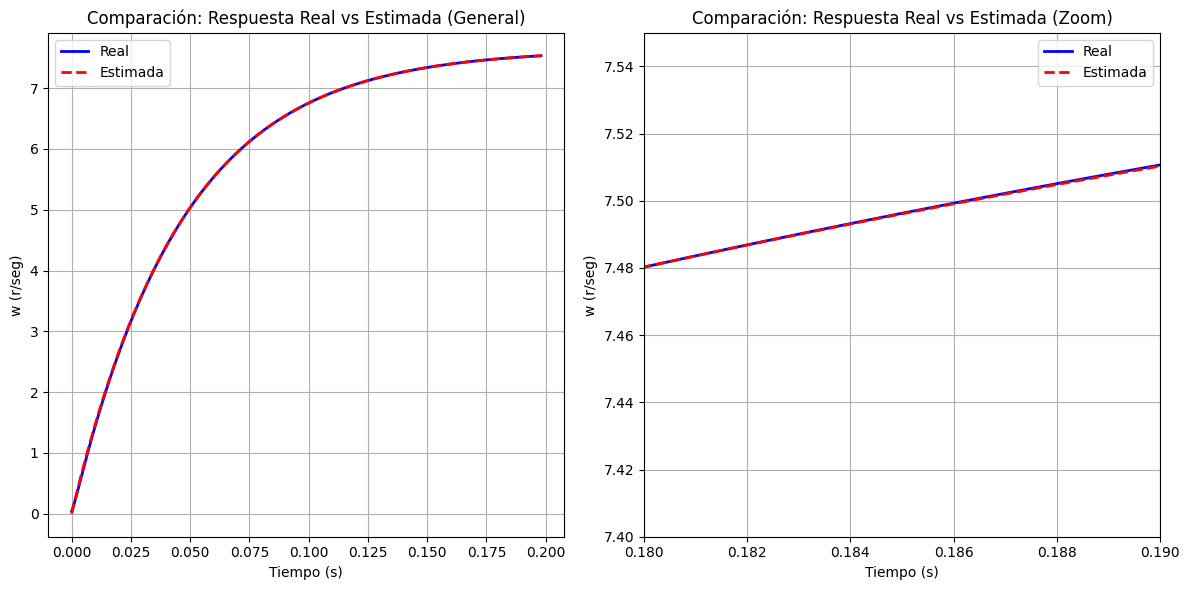

In [192]:

# Crear los subgráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico (general)
ax[0].plot(t, w, 'b', label='Real', linewidth=2)  # Datos reales en azul
ax[0].plot(t_estimada, y_estimada, 'r--', label='Estimada', linewidth=2)  # Modelo estimado en rojo
ax[0].set_title('Comparación: Respuesta Real vs Estimada (General)')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('w (r/seg)')
ax[0].legend(loc='best')
ax[0].grid(True)

# Segundo gráfico (zoom en el rango especificado)
ax[1].plot(t, w, 'b', label='Real', linewidth=2)  # Datos reales en azul
ax[1].plot(t_estimada, y_estimada, 'r--', label='Estimada', linewidth=2)  # Modelo estimado en rojo
ax[1].set_xlim(0.180, 0.19)  # Rango de tiempo de 0.075 a 0.1 s
ax[1].set_ylim(7.4, 7.55)  # Rango de w de 6 a 7
ax[1].set_title('Comparación: Respuesta Real vs Estimada (Zoom)')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('w (r/seg)')
ax[1].legend(loc='best')
ax[1].grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
#el modelo chen ajusta al escalon unitario, y aca tengo un escalon de 2V en el exceln,
#por eso tengo que poner escalon unitario para que me de igual que el metodo chen.


In [193]:
#lo siguiente a hacer es mostrar el modelo w/Va pero con entrada 12v, como yo se que mi modelo fue estimado para 2v, 
#con una entrada de 6v en el step estaria representado eso.

In [195]:
2. Modelo w/TL (Velocidad vs Torque de carga)

Esto es lo nuevo que tenés que agregar. Tu compañero hizo esto en MATLAB:

    Tomó los datos desde data(401:700, :) → es un tramo donde hay un escalón de torque (TL).

    Usó la misma lógica: método de Chen.

    Restó el valor inicial a w para que empiece desde cero.

    Invirtió la curva si era decreciente (porque cuando se aplica carga, la velocidad baja).
posible codigo. 
    
# Leer otra parte del archivo (donde se aplica escalón de torque)
t_tl = datos['Tiempo [Seg.]'].iloc[401:700].values
w_tl = datos['Velocidad angular [rad /seg]'].iloc[401:700].values
tl_tl = datos['Torque'].iloc[401:700].values

t_tl = t_tl - t_tl[0]  # Normalizo tiempo
w0 = w_tl[0]
w_tl_adj = w_tl - w0  # La respuesta arranca desde 0
w_tl_inv = w_tl_adj  # En este caso parece que ya sube, si bajara invertirías con: -w_tl_adj

StepAmplitude_TL = 0.12  # escalón aplicado de torque

# Método de Chen igual que antes
t_inic = 0.05
lugar = np.argmin(np.abs(t_inic - t_tl))
y_t1 = w_tl_inv[lugar]
t_t1 = t_tl[lugar]

lugar = np.argmin(np.abs(2 * t_inic - t_tl))
y_2t1 = w_tl_inv[lugar]

lugar = np.argmin(np.abs(3 * t_inic - t_tl))
y_3t1 = w_tl_inv[lugar]

# Parámetros
K_TL = w_tl_inv[-1] / StepAmplitude_TL
k1 = (y_t1 / StepAmplitude_TL) / K_TL - 1
k2 = (y_2t1 / StepAmplitude_TL) / K_TL - 1
k3 = (y_3t1 / StepAmplitude_TL) / K_TL - 1

be = 4 * k1**3 * k3 - 3 * k1**2 * k2**2 - 4 * k2**3 + k3**2 + 6 * k1 * k2 * k3
alfa1 = (k1 * k2 + k3 - np.sqrt(be)) / (2 * (k1**2 + k2))
alfa2 = (k1 * k2 + k3 + np.sqrt(be)) / (2 * (k1**2 + k2))
beta = (k1 + alfa2) / (alfa1 - alfa2)

T1_ang = -t_t1 / np.log(alfa1)
T2_ang = -t_t1 / np.log(alfa2)
T3_ang = beta * (T1_ang - T2_ang) + T1_ang

# Función de transferencia estimada
num_TL = [K_TL * T3_ang, K_TL]
den_TL = [T1_ang * T2_ang, T1_ang + T2_ang, 1]
system_TL = signal.TransferFunction(num_TL, den_TL)

# Simulación
t_tl_sim, w_tl_est = signal.step(system_TL, T=t_tl)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(t_tl, w_tl_inv, label='Real', linewidth=2)
plt.plot(t_tl_sim, w_tl_est, 'r--', label='Estimada (TL)', linewidth=2)
plt.title('Modelo estimado: w / TL')
plt.xlabel('Tiempo (s)')
plt.ylabel('w (rad/s)')
plt.legend()
plt.grid()
plt.show()


SyntaxError: invalid syntax (485755257.py, line 1)

In [196]:
y luego comparar con el modelo teorico. 
from scipy.signal import TransferFunction

# Parámetros físicos
La  = 0.105973
Ki  = 0.411
Jm  = 0.0594551
Km  = 0.64803
Bm  = 0.0594551
Ra  = 2.43309

a2 = La * Jm
a1 = Ra * Jm + La * Bm
a0 = Ra * Bm + Ki * Km

# Transferencia
w_va_teo = signal.TransferFunction([Ki], [a2, a1, a0])

# Simulación con escalón de 12V
t_teo, y_teo = signal.step(w_va_teo, T=t)
y_teo = 12 * y_teo

plt.plot(t, w, label='Real')
plt.plot(t_teo, y_teo, 'g:', label='Teórica 12V')
plt.legend()
plt.grid()
plt.title('Comparación Real vs Teórica')
plt.show()


SyntaxError: invalid syntax (936469999.py, line 1)